## Building a model to train on MNIST

For now: 
- Custom neural network with a Faltten function, x hidden layers of y units, an output layer
- Layers: linear layers, as seens in BurstCCN, also to stay simple and explainable (for the moment?)
- Activation functions: sigmoids (since the two models I have seen are using sigmoid functions)
- Loss: Pytorch MSEloss for the moment --> will code that manually so can custom it as the sum of 2 cost function ponderated by a factor each. Was learning when using CrossEntropyLoss but not with MSE, need to look.
- Gradient computation done using Pytorch loss directly --> may custom 
- Optimizer: Pytorch SGD for the moment  

Aim Features: 
- global cost function --> SST IN
- local cost function --> PV IN

Modules:

In [1]:
import os
import torch
import torchvision

/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E943EB88-577E-37A4-93E1-5DAFE97B5744> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Load MNIST dataset

In [96]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 32
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

In [97]:
print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


## Model

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [174]:
from modules.network import NeuralNetwork, Net
n_hidden_layers = 3
n_hidden_units = 500  # number of units per hidden layer
n_inputs = 28*28 # size of input images (28*28)
n_outputs = 10 # number of classes

model = NeuralNetwork(n_inputs= n_inputs,
                      n_outputs=n_outputs,
                      n_hidden_layers=n_hidden_layers,
                      n_hidden_units=n_hidden_units)


#model = Net()


In [175]:
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Flatten()
    (1): HiddenLayer(input_dim=784, output_dim=500)
    (2): HiddenLayer(input_dim=500, output_dim=500)
    (3): HiddenLayer(input_dim=500, output_dim=500)
    (4): OutputLayer(input_dim=500, output_dim=10)
  )
)


In [89]:
dummy_input = torch.randn(1, 1, 28, 28)
model(dummy_input)

tensor([[0.1113, 0.1434, 0.0899, 0.1091, 0.0551, 0.0952, 0.0868, 0.0863, 0.0952,
         0.1277]], grad_fn=<SoftmaxBackward0>)

## Initialisation

In [176]:
from modules.optimizer import SGDOptimizer, AdamOptimizer

learning_rate = 0.1 #0.4 when using CrossEntropyLoss cost function
momentum = 0.5

# optimizer = SGDOptimizer(model.parameters(), lr=learning_rate)
# optimizer = AdamOptimizer(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
n_epochs = 10
log_interval = 500

## Training

In [177]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(n_epochs + 1)]
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

def train(epoch, data_loader):
  model.train()
  for batch_idx, (data, target) in enumerate(data_loader):
    optimizer.zero_grad()
    output = model(data)
    t = F.one_hot(target, num_classes=10).float() # only if MSEloss
    loss = criterion(output, t)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      epoch, batch_idx * len(data), len(data_loader.dataset),
      100. * batch_idx / len(data_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(data_loader.dataset)))
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')


def test(data_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      t = F.one_hot(target, num_classes=10).float() # only if MSEloss
      test_loss += criterion(output, t).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss = test_loss / len(data_loader.dataset) * batch_size_test
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [178]:
test(test_data_loader)
for epoch in range(1, n_epochs + 1):
  train(epoch, train_data_loader)
  test(test_data_loader)


Test set: Avg. loss: 0.0912, Accuracy: 974/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.092409
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.089539
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.090043
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.090326

Test set: Avg. loss: 0.0900, Accuracy: 958/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.090039
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.090067
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.090203
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.089987

Test set: Avg. loss: 0.0900, Accuracy: 1145/10000 (11%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.090143
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.090155
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.090594
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.089680

Test set: Avg. loss: 0.0899, Accuracy: 1135/10000 (11%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.089460
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.089653
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.089345
Train Epoch: 4 [48000/60000 (80%)]	Loss:

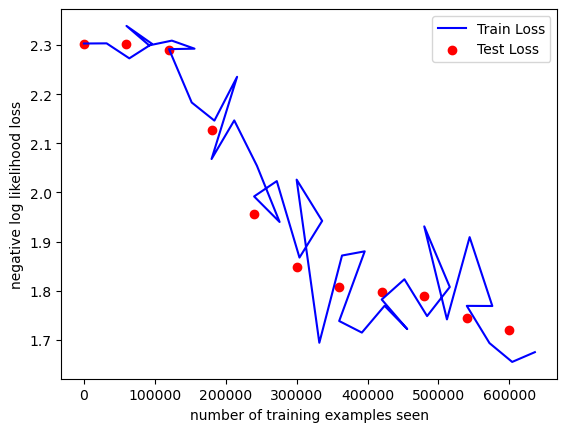

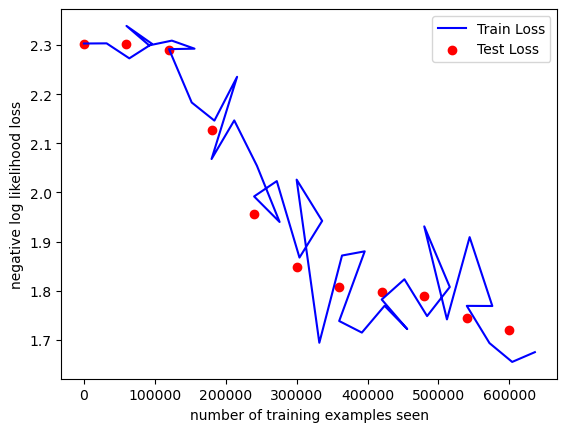

In [142]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Loss')
fig

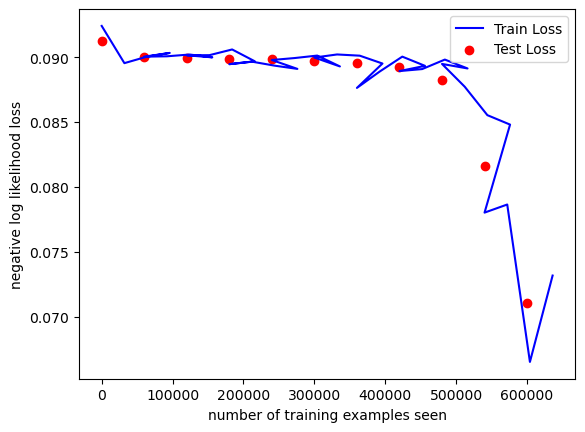

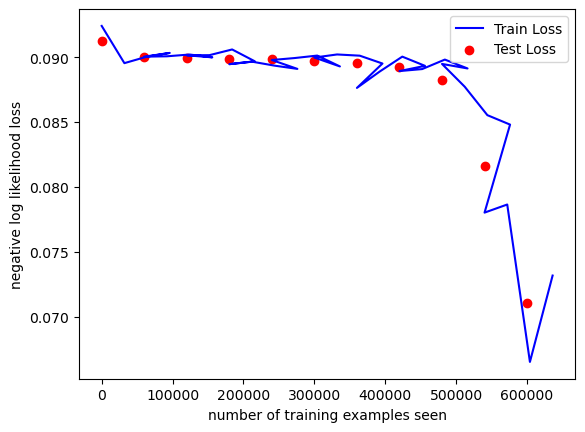

In [179]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Loss')
fig